Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [31]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [32]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (20000, 28, 28) (20000,)
Validation set (1000, 28, 28) (1000,)
Test set (1000, 28, 28) (1000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [33]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (20000, 784) (20000, 10)
Validation set (1000, 784) (1000, 10)
Test set (1000, 784) (1000, 10)


In [34]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [35]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
        tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)


In [36]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 20.390692
Minibatch accuracy: 6.2%
Validation accuracy: 10.7%
Minibatch loss at step 500: 2.857292
Minibatch accuracy: 73.4%
Validation accuracy: 76.7%
Minibatch loss at step 1000: 1.624007
Minibatch accuracy: 78.1%
Validation accuracy: 78.6%
Minibatch loss at step 1500: 1.053659
Minibatch accuracy: 85.9%
Validation accuracy: 80.4%
Minibatch loss at step 2000: 0.788145
Minibatch accuracy: 85.9%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 0.775562
Minibatch accuracy: 82.8%
Validation accuracy: 81.2%
Minibatch loss at step 3000: 0.595979
Minibatch accuracy: 88.3%
Validation accuracy: 82.4%
Test accuracy: 87.0%


The L2 regularization introduces a new meta parameter that should be tuned. Since I do not have any idea of what should be the right value for this meta parameter, I will plot the accuracy by the meta parameter value (in a logarithmic scale).


In [37]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []
print(regul_val)
for regul in regul_val:
    print("\nRegul", regul)
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            #if(step%100==0):
            #    print(step, end=''),
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
print("Complete!")


[0.0001, 0.00012589254117941674, 0.00015848931924611142, 0.00019952623149688809, 0.00025118864315095823, 0.00031622776601683826, 0.00039810717055349773, 0.00050118723362727296, 0.00063095734448019429, 0.00079432823472428294, 0.001000000000000002, 0.0012589254117941701, 0.0015848931924611173, 0.001995262314968885, 0.0025118864315095872, 0.0031622776601683889, 0.0039810717055349856, 0.0050118723362727402, 0.0063095734448019554, 0.0079432823472428467]

Regul 0.0001

Regul 0.000125892541179

Regul 0.000158489319246

Regul 0.000199526231497

Regul 0.000251188643151

Regul 0.000316227766017

Regul 0.000398107170553

Regul 0.000501187233627

Regul 0.00063095734448

Regul 0.000794328234724

Regul 0.001

Regul 0.00125892541179

Regul 0.00158489319246

Regul 0.00199526231497

Regul 0.00251188643151

Regul 0.00316227766017

Regul 0.00398107170553

Regul 0.00501187233627

Regul 0.0063095734448

Regul 0.00794328234724
Complete!


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline


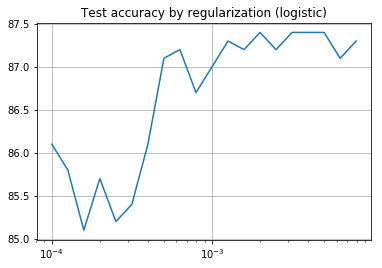

In [39]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()


Let's see if the same technique will improve the prediction of the 1-layer neural network:


In [40]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
  
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
            beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)


In [41]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 612.321777
Minibatch accuracy: 14.8%
Validation accuracy: 30.0%
Minibatch loss at step 500: 188.978821
Minibatch accuracy: 89.1%
Validation accuracy: 82.6%
Minibatch loss at step 1000: 114.474060
Minibatch accuracy: 93.0%
Validation accuracy: 83.3%
Minibatch loss at step 1500: 69.182533
Minibatch accuracy: 98.4%
Validation accuracy: 84.0%
Minibatch loss at step 2000: 41.935188
Minibatch accuracy: 100.0%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 25.481983
Minibatch accuracy: 100.0%
Validation accuracy: 85.0%
Minibatch loss at step 3000: 15.518349
Minibatch accuracy: 100.0%
Validation accuracy: 85.7%
Test accuracy: 92.1%


Minibatch accuracy seems to hit 100% very quickly, need to look into that.
90%+ is pretty good though, I will also plot the final accuracy by the L2 parameter to find the best value.

In [42]:
num_steps = 3001
regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:    
    print("Regul", regul)
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
print("Complete")

Regul 0.0001
Regul 0.000125892541179
Regul 0.000158489319246
Regul 0.000199526231497
Regul 0.000251188643151
Regul 0.000316227766017
Regul 0.000398107170553
Regul 0.000501187233627
Regul 0.00063095734448
Regul 0.000794328234724
Regul 0.001
Regul 0.00125892541179
Regul 0.00158489319246
Regul 0.00199526231497
Regul 0.00251188643151
Regul 0.00316227766017
Regul 0.00398107170553
Regul 0.00501187233627
Regul 0.0063095734448
Regul 0.00794328234724
Complete


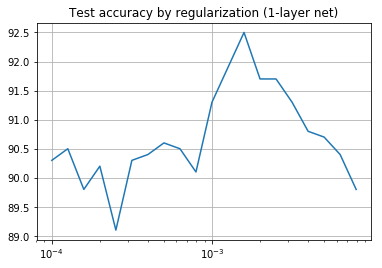

In [43]:
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (1-layer net)')
plt.show()


Well...there seems to be a clear peak.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [44]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)


In [45]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 338.939758
Minibatch accuracy: 7.0%
Validation accuracy: 42.8%
Minibatch loss at step 2: 879.787170
Minibatch accuracy: 32.8%
Validation accuracy: 45.9%
Minibatch loss at step 4: 550.042480
Minibatch accuracy: 56.2%
Validation accuracy: 64.5%
Minibatch loss at step 6: 98.326599
Minibatch accuracy: 69.5%
Validation accuracy: 68.1%
Minibatch loss at step 8: 61.705563
Minibatch accuracy: 72.7%
Validation accuracy: 67.9%
Minibatch loss at step 10: 28.984253
Minibatch accuracy: 85.9%
Validation accuracy: 75.2%
Minibatch loss at step 12: 31.273060
Minibatch accuracy: 88.3%
Validation accuracy: 70.8%
Minibatch loss at step 14: 6.845709
Minibatch accuracy: 93.0%
Validation accuracy: 75.2%
Minibatch loss at step 16: 0.439696
Minibatch accuracy: 99.2%
Validation accuracy: 75.7%
Minibatch loss at step 18: 8.043097
Minibatch accuracy: 99.2%
Validation accuracy: 74.0%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.7%
Mini

Since there are far too much parameters and no regularization, the accuracy of the batches is 100%. The generalization capability is poor, as shown in the validation and test accuracy. This seems to be a common problem.


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [46]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    logits = tf.matmul(drop1, weights2) + biases2
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)


In [47]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = step % num_batches
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 2 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 431.388123
Minibatch accuracy: 10.9%
Validation accuracy: 31.4%
Minibatch loss at step 2: 838.671448
Minibatch accuracy: 50.8%
Validation accuracy: 36.9%
Minibatch loss at step 4: 516.635132
Minibatch accuracy: 60.9%
Validation accuracy: 50.9%
Minibatch loss at step 6: 41.660938
Minibatch accuracy: 90.6%
Validation accuracy: 63.0%
Minibatch loss at step 8: 14.218320
Minibatch accuracy: 94.5%
Validation accuracy: 66.1%
Minibatch loss at step 10: 24.460960
Minibatch accuracy: 97.7%
Validation accuracy: 67.4%
Minibatch loss at step 12: 7.314364
Minibatch accuracy: 97.7%
Validation accuracy: 66.4%
Minibatch loss at step 14: 7.822986
Minibatch accuracy: 96.1%
Validation accuracy: 66.4%
Minibatch loss at step 16: 7.688788
Minibatch accuracy: 98.4%
Validation accuracy: 65.6%
Minibatch loss at step 18: 6.801603
Minibatch accuracy: 97.7%
Validation accuracy: 64.0%
Minibatch loss at step 20: 12.089335
Minibatch accuracy: 98.4%
Validation accuracy: 65.8%
Mini

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [48]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    logits = tf.matmul(lay2_train, weights3) + biases3
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)


In [49]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 3.294455
Minibatch accuracy: 7.8%
Validation accuracy: 43.6%
Minibatch loss at step 500: 0.975260
Minibatch accuracy: 89.1%
Validation accuracy: 86.8%
Minibatch loss at step 1000: 0.694582
Minibatch accuracy: 93.8%
Validation accuracy: 86.3%
Minibatch loss at step 1500: 0.497644
Minibatch accuracy: 96.9%
Validation accuracy: 86.8%
Minibatch loss at step 2000: 0.403403
Minibatch accuracy: 98.4%
Validation accuracy: 87.2%
Minibatch loss at step 2500: 0.384335
Minibatch accuracy: 97.7%
Validation accuracy: 86.7%
Minibatch loss at step 3000: 0.302243
Minibatch accuracy: 100.0%
Validation accuracy: 87.8%
Minibatch loss at step 3500: 0.308693
Minibatch accuracy: 99.2%
Validation accuracy: 86.9%
Minibatch loss at step 4000: 0.277125
Minibatch accuracy: 100.0%
Validation accuracy: 87.3%
Minibatch loss at step 4500: 0.297885
Minibatch accuracy: 99.2%
Validation accuracy: 87.3%
Minibatch loss at step 5000: 0.255196
Minibatch accuracy: 100.0%
Validation accur

Solid, looking good. Let's try even better.

In [50]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
    lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
    logits = tf.matmul(lay3_train, weights4) + biases4
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 4000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)


In [51]:
num_steps = 18001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 2.381812
Minibatch accuracy: 7.0%
Validation accuracy: 35.0%
Minibatch loss at step 500: 0.311826
Minibatch accuracy: 90.6%
Validation accuracy: 85.8%
Minibatch loss at step 1000: 0.153406
Minibatch accuracy: 94.5%
Validation accuracy: 85.8%
Minibatch loss at step 1500: 0.074019
Minibatch accuracy: 97.7%
Validation accuracy: 85.8%
Minibatch loss at step 2000: 0.044787
Minibatch accuracy: 99.2%
Validation accuracy: 86.8%
Minibatch loss at step 2500: 0.045148
Minibatch accuracy: 97.7%
Validation accuracy: 87.2%
Minibatch loss at step 3000: 0.004031
Minibatch accuracy: 100.0%
Validation accuracy: 87.7%
Minibatch loss at step 3500: 0.077380
Minibatch accuracy: 97.7%
Validation accuracy: 85.8%
Minibatch loss at step 4000: 0.025429
Minibatch accuracy: 100.0%
Validation accuracy: 86.6%
Minibatch loss at step 4500: 0.003826
Minibatch accuracy: 100.0%
Validation accuracy: 87.4%
Minibatch loss at step 5000: 0.000672
Minibatch accuracy: 100.0%
Validation accu

Minibatch reaches 100% really quickly still, not much improvement, one last try.

In [52]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 256
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
    weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
    weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
    weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    drop1 = tf.nn.dropout(lay1_train, 0.5)
    lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
    drop2 = tf.nn.dropout(lay2_train, 0.5)
    lay3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
    drop3 = tf.nn.dropout(lay3_train, 0.5)
    logits = tf.matmul(drop3, weights4) + biases4
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.80, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
    lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
    valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
    lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
    test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)


In [53]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 2.927011
Minibatch accuracy: 4.7%
Validation accuracy: 22.2%
Minibatch loss at step 500: 0.647787
Minibatch accuracy: 82.0%
Validation accuracy: 84.5%
Minibatch loss at step 1000: 0.590870
Minibatch accuracy: 80.5%
Validation accuracy: 85.2%
Minibatch loss at step 1500: 0.348589
Minibatch accuracy: 89.8%
Validation accuracy: 86.5%
Minibatch loss at step 2000: 0.394507
Minibatch accuracy: 84.4%
Validation accuracy: 87.4%
Minibatch loss at step 2500: 0.327000
Minibatch accuracy: 89.1%
Validation accuracy: 86.7%
Minibatch loss at step 3000: 0.234576
Minibatch accuracy: 93.8%
Validation accuracy: 86.6%
Minibatch loss at step 3500: 0.236246
Minibatch accuracy: 92.2%
Validation accuracy: 87.5%
Minibatch loss at step 4000: 0.375482
Minibatch accuracy: 89.1%
Validation accuracy: 87.3%
Minibatch loss at step 4500: 0.537382
Minibatch accuracy: 86.7%
Validation accuracy: 86.8%
Minibatch loss at step 5000: 0.310321
Minibatch accuracy: 92.2%
Validation accuracy

Minibatch accuracy always seems to be very high, really need to look into that. 
93% isnt bad, but isn't amazing. I might improve this later.